In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
import datetime as dt
from pandas.tseries.offsets import MonthEnd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import requests
from bs4 import BeautifulSoup as bs

In [2]:
df = pd.DataFrame()

In [3]:
S = yf.download('^GSPC', progress=False)[['Close']]
B = pdr.get_data_fred('DGS10', start='1962-01-02') / 100
C = yf.download('GD=F', progress=False)[['Close']]

In [4]:
# df['S_rv30'] = np.sqrt((np.log(S).diff()**2).rolling(30).sum()).dropna()
# df['S_rv90'] = np.sqrt((np.log(S).diff()**2).rolling(90).sum()).dropna()
# df['S_rv252'] = np.sqrt((np.log(S).diff()**2).rolling(252).sum()).dropna()

df['S_rv30'] = S.pct_change().dropna().rolling(30).std().apply(lambda x : x * np.sqrt(252))
df['S_rv90'] = S.pct_change().dropna().rolling(90).std().apply(lambda x : x * np.sqrt(252))
df['S_rv252'] = S.pct_change().dropna().rolling(252).std().apply(lambda x : x * np.sqrt(252))

df['B_rv30'] = np.sqrt((B**2).rolling(window=30, min_periods=1).sum().iloc[30:]).dropna()
df['B_rv90'] = np.sqrt((B**2).rolling(window=90, min_periods=1).sum().iloc[90:]).dropna()
df['B_rv252'] = np.sqrt((B**2).rolling(window=252, min_periods=1).sum().iloc[252:]).dropna()

df['C_rv30'] = np.sqrt((np.log(C).diff()**2).rolling(30).sum()).dropna()
df['C_rv90'] = np.sqrt((np.log(C).diff()**2).rolling(90).sum()).dropna()
df['C_rv252'] = np.sqrt((np.log(C).diff()**2).rolling(252).sum()).dropna()

In [5]:
fama    = pd.read_csv('Macro/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3, index_col=0, parse_dates=True)
dy      = pd.read_excel('Macro/S&P 500 Dividend Yield.xlsx', skiprows=1, index_col=0, parse_dates=True).iloc[:,[0]].rename(columns={'D-P':'DY'})
ep      = pd.read_excel('Macro/S&P 500 Earnings per Share.xlsx', skiprows=1, index_col=0, parse_dates=True).iloc[:,[0]].rename(columns={'E-P':'EP'}).sort_index().loc[fama.index[0]:]

ep.index = ep.index + MonthEnd()

In [6]:
TB = pdr.get_data_fred('DGS3MO', start='1962-01-02').rename(columns={'DGS3MO':'TB'}) / 100
TS = pdr.get_data_fred('T10Y2Y', start='1962-01-02').rename(columns={'T10Y2Y':'TS'}) / 100

In [7]:
F_eu = yf.download('6E=F', progress=False)[['Close']]
FS_eu = yf.download('EUR=X', progress=False)[['Close']]

FR_eu = (np.log(F_eu) - np.log(FS_eu).shift(1)).dropna().rename(columns={'Close':'FR_eu'})

F_jp = yf.download('6J=F', progress=False)[['Close']]
FS_jp = yf.download('JPYUSD=X', progress=False)[['Close']]

FR_jp = (np.log(F_jp) - np.log(FS_jp).shift(1)).dropna().rename(columns={'Close':'FR_jp'})

F_cad = yf.download('6S=F', progress=False)[['Close']]
FS_cad = yf.download('CADUSD=X', progress=False)[['Close']]

FR_cad = (np.log(F_cad) - np.log(FS_cad).shift(1)).dropna().rename(columns={'Close':'FR_cad'})

F_gbp = yf.download('6B=F', progress=False)[['Close']]
FS_gbp = yf.download('GBPUSD=X', progress=False)[['Close']]

FR_gbp = (np.log(F_gbp) - np.log(FS_gbp).shift(1)).dropna().rename(columns={'Close':'FR_gbp'})


In [8]:
url = "https://finance.yahoo.com/lookup/currency?s=USD&t=A&b=0&c=100"
url2 = "https://finance.yahoo.com/lookup/currency?s=USD&t=A&b=100&c=100"

headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36'}

response = requests.get(url, headers=headers)
response2 = requests.get(url2, headers=headers)

html = response.text
html2 = response2.text
soup = bs(html, 'html.parser')
soup2 = bs(html2, 'html.parser')

lst = [x.get_text() for x in soup.find_all('a', "Fw(b)")]
lst2 = [x.get_text() for x in soup2.find_all('a', "Fw(b)")]
fx_tickers = []

for x in lst:
    if '=' in x:
        fx_tickers.append(x)
    else:
        pass

for x in lst2:
    if '=' in x:
        fx_tickers.append(x)
    else:
        pass

len(pd.DataFrame(index=fx_tickers).index.unique())

fx_all = yf.download(fx_tickers)['Close']

# missing data sorting
ttt = fx_all.isna().sum()
ttt = fx_all[pd.Series(np.where(ttt.values < 2500, ttt.index, np.NaN)).dropna().to_numpy()].loc['2004-01-02':]
ttt = ttt.fillna(method='ffill').dropna()

# data resampling
aaaaa = ttt.resample('m').last().pct_change().dropna()
idx_fx = aaaaa.index

scaler = StandardScaler()
aaaaa = scaler.fit_transform(aaaaa)

for x in range(0, len(fx_all.columns)):
    
    pca = PCA(n_components=x)
    pca.fit_transform(aaaaa)
    
    if pca.explained_variance_ratio_.sum() < 0.9:
        pass
    else:
        n_comp = x
        break
    
pca = PCA(n_components=n_comp)
reg = pca.fit_transform(aaaaa)

DOL = aaaaa @ pca.components_[0]
DOL = pd.DataFrame(DOL, index=idx_fx).rename(columns={0:'DOL'})

[*********************100%***********************]  170 of 170 completed


carry trade factor는 일단 패스

In [9]:
TED = pdr.get_data_fred('TEDRATE', start='1962-01-02').fillna(method='pad').rename(columns={'TEDRATE':'TED'}) / 100
BAA = pdr.get_data_fred('BAA10Y', start='1962-01-02')
AAA = pdr.get_data_fred('AAA10Y', start='1962-01-02')
tmp = pd.concat([BAA, AAA],axis=1).dropna() / 100
DEF = pd.DataFrame(tmp.iloc[:,0] - tmp.iloc[:,1], columns=['DEF']).rename_axis(index={'DATE':'date'})

In [10]:
INF = pdr.get_data_fred('CPIAUCSL', start='1962-01-02').pct_change(periods=12).dropna().rename(columns={'CPIAUCSL':'CPI'})
INF.index = INF.index + MonthEnd()

EMP = pdr.get_data_fred('UNRATE', start='1962-01-02').rename(columns={'UNRATE':'EMP'}) / 100
EMP = (EMP - EMP.shift(12)).dropna()

# Home Price Index (직전대비 변화율이 맞나 yoy가 맞나)
HPI = pdr.get_data_fred('CSUSHPINSA', start='1962-01-02').rename(columns={'CSUSHPINSA':'HPI'}).pct_change().dropna()



In [11]:
# For Pattern, YOY seems better
M1 = pdr.get_data_fred('M1SL', start='1962-01-02').rename(columns={'M1SL':'M1'}).pct_change(12).dropna()

SVR = pdr.get_data_fred('PSAVERT', start='1962-01-02').rename(columns={'PSAVERT':'SVR'})

# 개인 가계 소비 (YOY로 사용)
PCE = pdr.get_data_fred('PCE', start='1962-01-02').pct_change(12).dropna()

# monthly assemble

In [12]:
test = pd.concat([
                    #fama.resample('m').mean().iloc[:,:-1],
                    dy.sort_index().resample('m').last(),
                    ep,
                    TB.interpolate().resample('m').last(),
                    TS.interpolate().resample('m').last(),
                    pd.concat([FR_eu, FR_jp, FR_cad, FR_gbp],axis=1).resample('m').last().dropna(),
                    DOL,
                    TED.resample('m').last(),
                    DEF.resample('m').last(),
                    pd.concat([INF, EMP, HPI, M1, SVR, PCE],axis=1).resample('m').last().dropna()
], axis=1).dropna()
test

,DY,EP,TB,TS,FR_eu,FR_jp,FR_cad,FR_gbp,DOL,TED,DEF,CPI,EMP,HPI,M1,SVR,PCE
2006-06-30,1.85,74.49,0.0501,-0.0001,0.486937,0.016862,-0.089734,0.012238,0.963844,0.0061,0.0091,0.041817,-0.004,0.000911,-0.003406,3.7,0.057829
2006-07-31,1.85,75.85,0.0510,0.0002,0.490903,0.007845,-0.078647,0.002672,-1.264632,0.0050,0.0088,0.041047,-0.003,0.000325,0.002484,3.1,0.055343
2006-08-31,1.83,77.21,0.0505,-0.0005,0.498708,-0.000767,-0.102787,0.000059,-0.151979,0.0048,0.0093,0.039266,-0.002,-0.001100,-0.003919,3.3,0.055604
2006-09-30,1.80,78.57,0.0489,-0.0007,0.481381,0.007622,-0.110951,-0.001974,1.336261,0.0060,0.0094,0.020121,-0.005,-0.001117,-0.010300,3.2,0.053368
2006-10-31,1.77,79.55,0.0508,-0.0010,0.486977,0.012311,-0.094931,0.004409,-3.690833,0.0042,0.0086,0.014063,-0.006,-0.000782,-0.004504,3.2,0.050915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,1.38,175.43,0.0004,0.0124,0.303177,0.001298,0.308780,-0.004978,3.414917,0.0009,0.0067,0.053836,-0.031,0.009865,0.157781,7.9,0.115523
2021-10-31,1.30,182.91,0.0005,0.0107,0.293569,-0.001161,0.302140,-0.003200,-2.243999,0.0008,0.0065,0.062378,-0.024,0.008155,0.154282,7.3,0.126322
2021-11-30,1.31,190.39,0.0005,0.0091,0.246174,0.005488,0.326136,-0.004431,6.834430,0.0012,0.0067,0.068624,-0.025,0.008674,0.149996,7.1,0.137140
2021-12-31,1.27,197.87,0.0006,0.0079,0.257633,-0.000642,0.340082,0.002679,-1.867708,0.0015,0.0066,0.071945,-0.028,0.009338,0.149717,7.5,0.133916


In [13]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]

X = sm.add_constant(X)
reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     42.16
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           2.91e-47
Time:                        16:02:04   Log-Likelihood:                 274.48
No. Observations:                 158   AIC:                            -511.0
Df Residuals:                     139   BIC:                            -452.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2702      0.108     -2.500      0.014      -0.484      -0.057
S_rv30         0.2541      0.064      3.981      0.000       0.128       0.380
DY             0.0189      0.039      0.481      0.631      -0.059       0.097
EP             0.0008      0.000      1.550      0.123      -0.000       0.002
TB             2.2002      0.978      2.250      0.026       0.267       4.134
TS             4.2284      1.456      2.904      0.004       1.349       7.107
FR_eu          0.0056      0.042      0.132      0.895      -0.078       0.089
FR_jp          0.3372      0.420      0.804      0.423      -0.492       1.167
FR_cad         0.1174      0.066      1.771      0.079      -0.014       0.249
FR_gbp        -1.9973      0.666     -3.000      0.003      -3.314      -0.681
DOL           -0.0004      0.001     -0.459      0.647      -0.002       0.001
TED            6.1621      1.563      3.943      0.000       3.072       9.252
DEF           12.4699      2.193      5.687      0.000       8.135      16.805
CPI           -0.7707      0.606     -1.271      0.206      -1.969       0.428
EMP            0.0570      0.838      0.068      0.946      -1.601       1.714
HPI           -1.2342      0.581     -2.124      0.035      -2.383      -0.085
M1             0.3682      0.139      2.642      0.009       0.093       0.644
SVR           -0.0028      0.005     -0.525      0.601      -0.013       0.008
PCE            0.6469      0.752      0.860      0.391      -0.841       2.135
==============================================================================
Omnibus:                        7.112   Durbin-Watson:                   1.571
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.505
Skew:                           0.372   Prob(JB):                       0.0235
Kurtosis:                       3.767   Cond. No.                     5.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
X = [['const', 'S_rv30', 'DY', 'EP', 'TB', 'TS', 'FR_eu', 'FR_jp', 'FR_cad', \
        'FR_gbp', 'DOL', 'TED', 'DEF', 'CPI', 'HPI', 'M1', 'SVR', 'PCE']]

In [15]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]

X = sm.add_constant(X)
X = X[['const', 'S_rv30', 'DY', 'EP', 'TB', 'TS', 'FR_eu', 'FR_jp', 'FR_cad', \
        'FR_gbp', 'DOL', 'TED', 'DEF', 'CPI', 'HPI', 'M1', 'SVR', 'PCE']]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     44.96
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           4.27e-48
Time:                        16:02:04   Log-Likelihood:                 274.48
No. Observations:                 158   AIC:                            -513.0
Df Residuals:                     140   BIC:                            -457.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2681      0.103     -2.606      0.010      -0.471      -0.065
S_rv30         0.2543      0.063      4.005      0.000       0.129       0.380
DY             0.0188      0.039      0.479      0.632      -0.059       0.096
EP             0.0008      0.000      1.881      0.062   -3.85e-05       0.002
TB             2.2185      0.937      2.369      0.019       0.367       4.070
TS             4.2341      1.448      2.923      0.004       1.370       7.098
FR_eu          0.0057      0.042      0.135      0.893      -0.078       0.089
FR_jp          0.3349      0.417      0.804      0.423      -0.489       1.159
FR_cad         0.1189      0.062      1.909      0.058      -0.004       0.242
FR_gbp        -2.0020      0.660     -3.034      0.003      -3.307      -0.697
DOL           -0.0004      0.001     -0.457      0.648      -0.002       0.001
TED            6.1602      1.557      3.957      0.000       3.082       9.238
DEF           12.4383      2.135      5.826      0.000       8.218      16.659
CPI           -0.7552      0.559     -1.350      0.179      -1.861       0.351
HPI           -1.2409      0.571     -2.174      0.031      -2.369      -0.113
M1             0.3651      0.132      2.775      0.006       0.105       0.625
SVR           -0.0027      0.005     -0.528      0.598      -0.013       0.007
PCE            0.6161      0.599      1.029      0.305      -0.567       1.800
==============================================================================
Omnibus:                        7.112   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                7.502
Skew:                           0.372   Prob(JB):                       0.0235
Kurtosis:                       3.766   Cond. No.                     5.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]

X = sm.add_constant(X)
X = X[['const', 'S_rv30', 'DY', 'EP', 'TB', 'TS', 'FR_jp', 'FR_cad', \
        'FR_gbp', 'DOL', 'TED', 'DEF', 'CPI', 'HPI', 'M1', 'PCE']]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     51.54
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           9.65e-50
Time:                        16:02:04   Log-Likelihood:                 274.30
No. Observations:                 158   AIC:                            -516.6
Df Residuals:                     142   BIC:                            -467.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2798      0.099     -2.825      0.005      -0.476      -0.084
S_rv30         0.2516      0.063      3.998      0.000       0.127       0.376
DY             0.0200      0.039      0.514      0.608      -0.057       0.097
EP             0.0006      0.000      1.898      0.060   -2.66e-05       0.001
TB             2.4564      0.814      3.016      0.003       0.846       4.066
TS             4.4899      1.243      3.612      0.000       2.033       6.947
FR_jp          0.3196      0.413      0.774      0.440      -0.497       1.136
FR_cad         0.1166      0.058      1.997      0.048       0.001       0.232
FR_gbp        -2.0371      0.644     -3.162      0.002      -3.311      -0.764
DOL           -0.0004      0.001     -0.508      0.612      -0.002       0.001
TED            6.4628      1.450      4.458      0.000       3.597       9.329
DEF           12.0272      1.993      6.035      0.000       8.088      15.967
CPI           -0.7452      0.497     -1.501      0.136      -1.727       0.236
HPI           -1.2794      0.559     -2.289      0.024      -2.384      -0.174
M1             0.3658      0.125      2.926      0.004       0.119       0.613
PCE            0.6546      0.569      1.150      0.252      -0.470       1.779
==============================================================================
Omnibus:                        6.755   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                7.061
Skew:                           0.358   Prob(JB):                       0.0293
Kurtosis:                       3.748   Cond. No.                     5.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]

X = sm.add_constant(X)
X = X[['const', 'S_rv30', 'DY', 'EP', 'TB', 'TS', 'FR_jp', 'FR_cad', \
        'FR_gbp', 'TED', 'DEF', 'CPI', 'HPI', 'M1', 'PCE']]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     55.49
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.44e-50
Time:                        16:02:04   Log-Likelihood:                 274.16
No. Observations:                 158   AIC:                            -518.3
Df Residuals:                     143   BIC:                            -472.4
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2659      0.095     -2.801      0.006      -0.454      -0.078
S_rv30         0.2424      0.060      4.033      0.000       0.124       0.361
DY             0.0143      0.037      0.384      0.701      -0.059       0.088
EP             0.0006      0.000      1.849      0.067   -4.29e-05       0.001
TB             2.4790      0.811      3.056      0.003       0.876       4.082
TS             4.5085      1.239      3.638      0.000       2.059       6.958
FR_jp          0.3119      0.412      0.758      0.450      -0.502       1.125
FR_cad         0.1207      0.058      2.092      0.038       0.007       0.235
FR_gbp        -1.9621      0.625     -3.137      0.002      -3.198      -0.726
TED            6.5093      1.443      4.511      0.000       3.657       9.362
DEF           12.2225      1.950      6.267      0.000       8.367      16.078
CPI           -0.7320      0.495     -1.480      0.141      -1.710       0.246
HPI           -1.2877      0.557     -2.311      0.022      -2.389      -0.186
M1             0.3630      0.125      2.914      0.004       0.117       0.609
PCE            0.5992      0.557      1.076      0.284      -0.502       1.700
==============================================================================
Omnibus:                        6.458   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.040   Jarque-Bera (JB):                6.801
Skew:                           0.339   Prob(JB):                       0.0334
Kurtosis:                       3.758   Cond. No.                     4.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]

X = sm.add_constant(X)
X = X[['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_jp', 'FR_cad', \
        'FR_gbp', 'TED', 'DEF', 'CPI', 'HPI', 'M1', 'PCE']]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     60.10
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.95e-51
Time:                        16:02:04   Log-Likelihood:                 274.08
No. Observations:                 158   AIC:                            -520.2
Df Residuals:                     144   BIC:                            -477.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2358      0.053     -4.420      0.000      -0.341      -0.130
S_rv30         0.2454      0.059      4.131      0.000       0.128       0.363
EP             0.0006      0.000      1.821      0.071   -4.95e-05       0.001
TB             2.4353      0.801      3.041      0.003       0.853       4.018
TS             4.4334      1.220      3.634      0.000       2.022       6.845
FR_jp          0.2988      0.409      0.731      0.466      -0.510       1.107
FR_cad         0.1267      0.055      2.288      0.024       0.017       0.236
FR_gbp        -1.9482      0.623     -3.130      0.002      -3.179      -0.718
TED            6.5417      1.436      4.554      0.000       3.703       9.381
DEF           12.6746      1.551      8.172      0.000       9.609      15.740
CPI           -0.7130      0.491     -1.453      0.148      -1.683       0.257
HPI           -1.2857      0.556     -2.314      0.022      -2.384      -0.188
M1             0.3623      0.124      2.917      0.004       0.117       0.608
PCE            0.5180      0.514      1.008      0.315      -0.498       1.534
==============================================================================
Omnibus:                        6.357   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.548
Skew:                           0.345   Prob(JB):                       0.0378
Kurtosis:                       3.720   Cond. No.                     4.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]

X = sm.add_constant(X)
X = X[['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_cad', \
        'FR_gbp', 'TED', 'DEF', 'CPI', 'HPI', 'M1', 'PCE']]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     65.28
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           3.07e-52
Time:                        16:02:04   Log-Likelihood:                 273.78
No. Observations:                 158   AIC:                            -521.6
Df Residuals:                     145   BIC:                            -481.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2312      0.053     -4.372      0.000      -0.336      -0.127
S_rv30         0.2442      0.059      4.119      0.000       0.127       0.361
EP             0.0006      0.000      1.759      0.081   -6.89e-05       0.001
TB             2.4495      0.799      3.065      0.003       0.870       4.029
TS             4.3978      1.217      3.613      0.000       1.992       6.803
FR_cad         0.1250      0.055      2.264      0.025       0.016       0.234
FR_gbp        -1.9067      0.619     -3.081      0.002      -3.130      -0.683
TED            6.4891      1.432      4.531      0.000       3.658       9.320
DEF           12.6221      1.547      8.160      0.000       9.565      15.679
CPI           -0.7117      0.490     -1.453      0.148      -1.680       0.256
HPI           -1.2570      0.553     -2.272      0.025      -2.351      -0.163
M1             0.3582      0.124      2.892      0.004       0.113       0.603
PCE            0.5132      0.513      1.000      0.319      -0.501       1.527
==============================================================================
Omnibus:                        7.718   Durbin-Watson:                   1.578
Prob(Omnibus):                  0.021   Jarque-Bera (JB):                8.429
Skew:                           0.383   Prob(JB):                       0.0148
Kurtosis:                       3.833   Cond. No.                     4.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]

X = sm.add_constant(X)
X = X[['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_cad', \
        'FR_gbp', 'TED', 'DEF', 'CPI', 'HPI', 'M1']]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     71.12
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           5.80e-53
Time:                        16:02:04   Log-Likelihood:                 273.24
No. Observations:                 158   AIC:                            -522.5
Df Residuals:                     146   BIC:                            -485.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2141      0.050     -4.278      0.000      -0.313      -0.115
S_rv30         0.2420      0.059      4.085      0.000       0.125       0.359
EP             0.0007      0.000      2.530      0.012       0.000       0.001
TB             2.2860      0.782      2.922      0.004       0.740       3.832
TS             4.2187      1.204      3.504      0.001       1.839       6.598
FR_cad         0.1100      0.053      2.070      0.040       0.005       0.215
FR_gbp        -1.9246      0.619     -3.111      0.002      -3.147      -0.702
TED            6.4318      1.431      4.494      0.000       3.604       9.260
DEF           12.0485      1.437      8.387      0.000       9.209      14.888
CPI           -0.4248      0.397     -1.070      0.287      -1.210       0.360
HPI           -1.3653      0.543     -2.516      0.013      -2.438      -0.293
M1             0.3111      0.115      2.715      0.007       0.085       0.537
==============================================================================
Omnibus:                        9.266   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.010   Jarque-Bera (JB):               10.718
Skew:                           0.424   Prob(JB):                      0.00471
Kurtosis:                       3.953   Cond. No.                     4.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Stats

In [21]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]

X = sm.add_constant(X)
X = X[['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_cad', \
        'FR_gbp', 'TED', 'DEF', 'HPI', 'M1']]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     78.04
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.12e-53
Time:                        16:02:04   Log-Likelihood:                 272.62
No. Observations:                 158   AIC:                            -523.2
Df Residuals:                     147   BIC:                            -489.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2092      0.050     -4.195      0.000      -0.308      -0.111
S_rv30         0.2350      0.059      3.989      0.000       0.119       0.351
EP             0.0006      0.000      2.292      0.023    8.11e-05       0.001
TB             2.1747      0.776      2.803      0.006       0.642       3.708
TS             4.0460      1.194      3.390      0.001       1.687       6.405
FR_cad         0.1238      0.052      2.400      0.018       0.022       0.226
FR_gbp        -1.9149      0.619     -3.094      0.002      -3.138      -0.692
TED            5.8082      1.308      4.442      0.000       3.224       8.392
DEF           12.4225      1.394      8.911      0.000       9.667      15.177
HPI           -1.2843      0.538     -2.389      0.018      -2.347      -0.222
M1             0.2941      0.114      2.591      0.011       0.070       0.518
==============================================================================
Omnibus:                        7.458   Durbin-Watson:                   1.557
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.913
Skew:                           0.386   Prob(JB):                       0.0191
Kurtosis:                       3.779   Cond. No.                     4.09e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

샘플이 작아도 유의미한가? 예스!

In [22]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-90]
Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-80:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-90]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-80:]

X = sm.add_constant(X)
X = X[['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_cad', \
        'FR_gbp', 'TED', 'DEF', 'HPI', 'M1']]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     57.58
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           4.69e-34
Time:                        16:02:04   Log-Likelihood:                 164.51
No. Observations:                  98   AIC:                            -307.0
Df Residuals:                      87   BIC:                            -278.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1945      0.082     -2.368      0.020      -0.358      -0.031
S_rv30         0.2557      0.074      3.469      0.001       0.109       0.402
EP             0.0006      0.000      1.555      0.124      -0.000       0.001
TB             1.9183      1.054      1.819      0.072      -0.177       4.014
TS             3.4953      1.813      1.928      0.057      -0.108       7.099
FR_cad         0.1174      0.098      1.204      0.232      -0.076       0.311
FR_gbp        -1.9930      0.865     -2.304      0.024      -3.713      -0.273
TED            5.3392      1.647      3.241      0.002       2.065       8.614
DEF           12.1191      1.955      6.198      0.000       8.233      16.006
HPI           -1.3564      0.622     -2.179      0.032      -2.594      -0.119
M1             0.2885      0.169      1.710      0.091      -0.047       0.624
==============================================================================
Omnibus:                        5.011   Durbin-Watson:                   1.457
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                4.589
Skew:                           0.378   Prob(JB):                        0.101
Kurtosis:                       3.743   Cond. No.                     3.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

대입해가면서 진행, outsample 최신 30개월로

In [23]:
y_hat = []

Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]
X_out = pd.concat([df[['S_rv30']].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]
X_out = sm.add_constant(X_out)

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X = sm.add_constant(X)

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
factors = ['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_cad', 'FR_gbp', 'TED', 'DEF', 'HPI', 'M1']


for idx in range(len(Y_out)):

    reg = sm.OLS(Y.iloc[-158:], X[factors].iloc[-158:]).fit()

    y_f = reg.params @ X_out[factors].iloc[idx]
    y_hat.append(y_f)
    
    X = pd.concat([X, X_out.iloc[[idx]]])
    Y = pd.concat([Y, Y_out.iloc[[idx]]])
    
y_df = pd.DataFrame(y_hat, index=Y_out.index, columns=['y_pred'])
Y_out = pd.DataFrame(Y_out)
y_reg = pd.concat([y_df, Y_out], axis=1)

<AxesSubplot:>

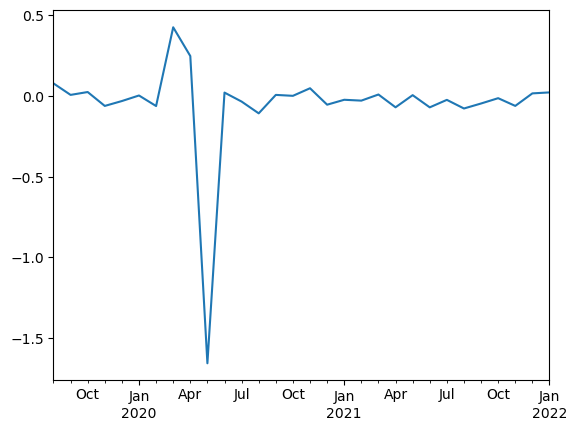

In [24]:
#y_reg.plot(),

(y_reg['S_rv30'] - y_reg['y_pred']).plot()

In [25]:
def mae (y, y_hat):
    return sum(abs(y-y_hat)) / len(y_hat)
def mse (y, y_hat):
    return sum((y-y_hat)**2) / len(y_hat)
def rmse (y, y_hat):
    return np.sqrt(sum((y-y_hat)**2) / len(y_hat))
# def mse (y, y_hat):
#     return sum((y-y_hat)**2) / len(y_hat)
    
print(f'Mean Absolute Error : {mae(y_reg.S_rv30, y_reg.y_pred)}')
print(f'Mean Squared Error : {mse(y_reg.S_rv30, y_reg.y_pred)}')
print(f'Root Mean Squared Error : {rmse(y_reg.S_rv30, y_reg.y_pred)}')

Mean Absolute Error : 0.11118003012042345
Mean Squared Error : 0.10124457449431798
Root Mean Squared Error : 0.318189526060048


아웃샘플 약 

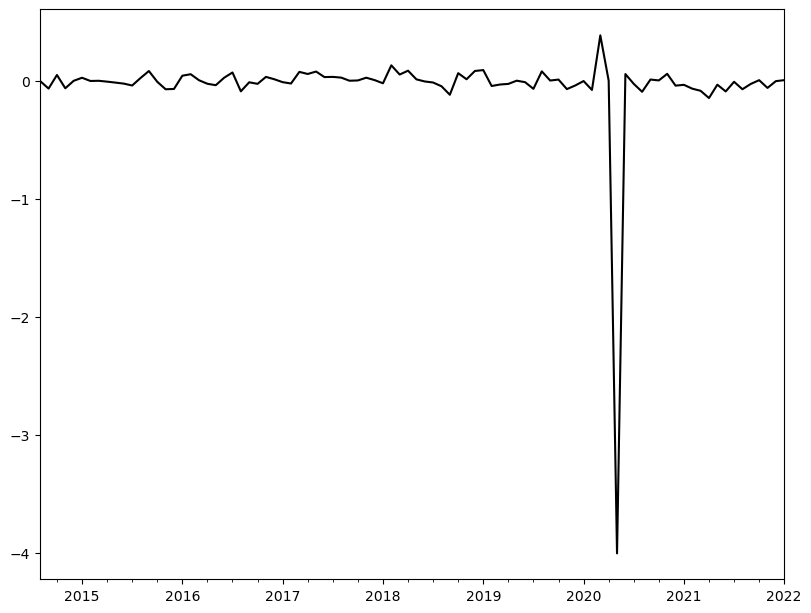

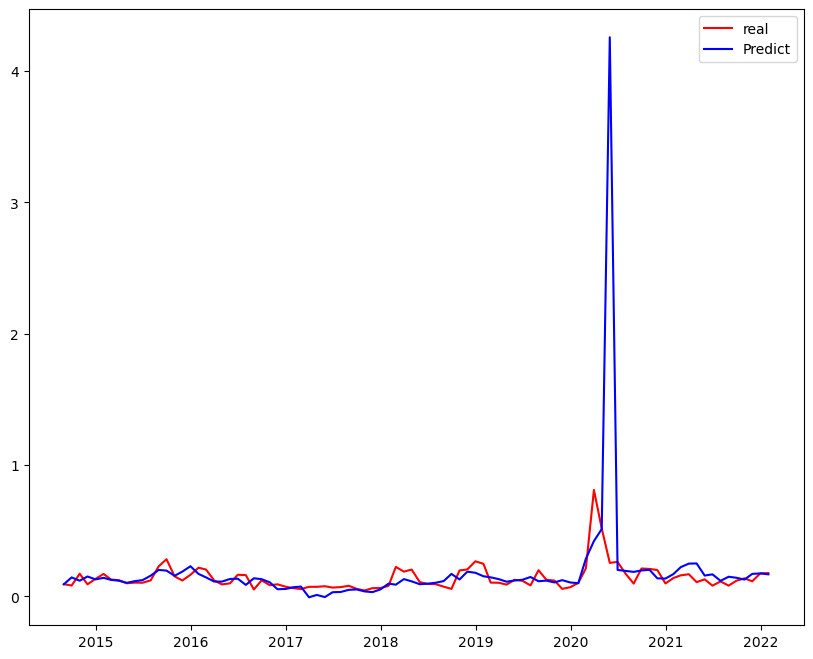

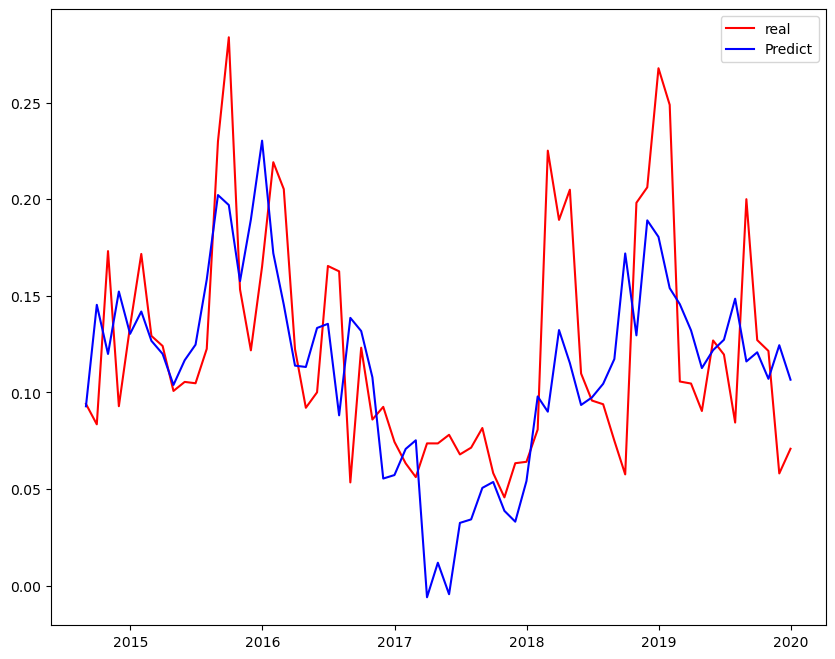

Mean Absolute Error : 0.08755088903871311
Mean Squared Error : 0.18217642048335358
Root Mean Squared Error : 0.42682129806671265


In [26]:
import matplotlib.pyplot as plt

y_hat = []

Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-90:]
X_out = pd.concat([df[['S_rv30']].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-90:]
X_out = sm.add_constant(X_out)

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-90]
X = sm.add_constant(X)

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-90]
factors = ['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_cad', 'FR_gbp', 'TED', 'DEF', 'HPI', 'M1']


for idx in range(len(Y_out)):

    reg = sm.OLS(Y.iloc[-90:], X[factors].iloc[-90:]).fit()

    y_f = reg.params @ X_out[factors].iloc[idx]
    y_hat.append(y_f)
    
    X = pd.concat([X, X_out.iloc[[idx]]])
    Y = pd.concat([Y, Y_out.iloc[[idx]]])
    
y_df = pd.DataFrame(y_hat, index=Y_out.index, columns=['y_pred'])
Y_out = pd.DataFrame(Y_out)
y_reg = pd.concat([y_df, Y_out], axis=1)

(y_reg['S_rv30'] - y_reg['y_pred']).plot(figsize=(9.6, 7.4), color='k')
plt.figure(figsize=(10,8))
plt.plot(y_reg['S_rv30'], color='r', label='real')
plt.plot(y_reg['y_pred'], color='b', label='Predict')
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.plot(y_reg['S_rv30'].loc[:'2019'], color='r', label='real')
plt.plot(y_reg['y_pred'].loc[:'2019'], color='b', label='Predict')
plt.legend()
plt.show()

def mae (y, y_hat):
    return sum(abs(y-y_hat)) / len(y_hat)
def mse (y, y_hat):
    return sum((y-y_hat)**2) / len(y_hat)
def rmse (y, y_hat):
    return np.sqrt(sum((y-y_hat)**2) / len(y_hat))
# def mse (y, y_hat):
#     return sum((y-y_hat)**2) / len(y_hat)
    
print(f'Mean Absolute Error : {mae(y_reg.S_rv30, y_reg.y_pred)}')
print(f'Mean Squared Error : {mse(y_reg.S_rv30, y_reg.y_pred)}')
print(f'Root Mean Squared Error : {rmse(y_reg.S_rv30, y_reg.y_pred)}')

In [27]:
# y_hat_arr = np.array([])

# new_X = X
# new_Y = Y
# for x in range(len(Y_out)):

#     X = sm.add_constant(new_X)
#     reg = sm.OLS(new_Y, X).fit()

#     y_hat = (np.hstack([np.ones((1)), X_out.iloc[-1].to_numpy()]) @ reg.params).item()
#     y_hat_arr = np.append(y_hat_arr, y_hat)
    
#     new_X = pd.concat([new_X, X_out.iloc[[x]]])
#     new_X = pd.concat([new_Y, Y_out.iloc[[x]]])

In [28]:
factors = [fama.iloc[:,:-1], dy, ep, TB, TS, FR_eu, FR_jp, FR_cad, FR_gbp, DOL, TED, DEF, INF, EMP, HPI, M1, SVR, PCE]

pd.concat(factors, axis=1).resample('w').last().dropna()

,Mkt-RF,SMB,HML,RMW,CMA,DY,EP,TB,TS,FR_eu,...,FR_gbp,DOL,TED,DEF,CPI,EMP,HPI,M1,SVR,PCE
2006-07-02,-0.02,1.18,0.07,-0.22,0.23,1.85,74.49,0.0501,-0.0001,0.486937,...,0.012238,0.963844,0.0061,0.0091,0.041817,-0.003,0.000325,0.002484,3.1,0.055343
2006-08-06,-0.13,-0.44,0.05,0.08,0.01,1.87,75.85,0.0509,0.0000,0.502510,...,0.012017,-1.264632,0.0054,0.0089,0.041047,-0.002,-0.001100,-0.003919,3.3,0.055604
2006-09-03,0.49,-0.28,-0.10,0.26,-0.03,1.84,77.21,0.0502,-0.0004,0.498245,...,0.001368,-0.151979,0.0050,0.0093,0.039266,-0.005,-0.001117,-0.010300,3.2,0.053368
2006-10-01,-0.33,-0.61,0.20,-0.35,0.01,1.80,78.57,0.0489,-0.0007,0.481381,...,-0.001974,1.336261,0.0060,0.0094,0.020121,-0.006,-0.000782,-0.004504,3.2,0.050915
2006-11-05,-0.12,0.56,-0.02,-0.04,-0.14,1.81,79.55,0.0509,-0.0010,0.487854,...,-0.003367,-3.690833,0.0041,0.0085,0.014063,-0.005,-0.002293,-0.003851,3.6,0.050748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,-0.65,-0.08,-0.17,0.56,0.39,1.32,164.32,0.0006,0.0105,0.339946,...,-0.001069,0.665141,0.0006,0.0068,0.052215,-0.032,0.012325,0.169192,9.5,0.124937
2021-09-05,-0.01,-0.55,-0.26,0.04,-0.27,1.31,169.87,0.0005,0.0112,0.342298,...,0.007838,0.119047,0.0007,0.0070,0.051883,-0.031,0.009865,0.157781,7.9,0.115523
2021-10-03,1.10,0.47,0.50,-0.10,0.61,1.37,175.43,0.0004,0.0121,0.297021,...,0.009457,3.414917,0.0009,0.0068,0.053836,-0.024,0.008155,0.154282,7.3,0.126322
2021-12-05,-1.21,-0.87,1.06,1.79,1.01,1.33,190.39,0.0006,0.0075,0.247355,...,-0.003772,6.834430,0.0013,0.0067,0.068624,-0.028,0.009338,0.149717,7.5,0.133916


In [29]:
test2 = pd.concat([
                    fama.resample('m').mean().iloc[:,:-1],
                    dy.sort_index().resample('m').last(),
                    ep,
                    TB.interpolate().resample('m').last(),
                    TS.interpolate().resample('m').last(),
                    pd.concat([FR_eu, FR_jp, FR_cad, FR_gbp],axis=1).resample('m').last().dropna(),
                    DOL,
                    TED.resample('m').last(),
                    DEF.resample('m').last(),
                    pd.concat([INF, EMP, HPI, M1, SVR, PCE],axis=1).resample('m').last().dropna()
], axis=1).dropna()
test2

,Mkt-RF,SMB,HML,RMW,CMA,DY,EP,TB,TS,FR_eu,...,FR_gbp,DOL,TED,DEF,CPI,EMP,HPI,M1,SVR,PCE
2006-06-30,-0.011818,-0.002273,0.035909,0.060000,-0.003636,1.85,74.49,0.0501,-0.0001,0.486937,...,0.012238,0.963844,0.0061,0.0091,0.041817,-0.004,0.000911,-0.003406,3.7,0.057829
2006-07-31,-0.034000,-0.176500,0.130500,0.084000,0.049500,1.85,75.85,0.0510,0.0002,0.490903,...,0.002672,-1.264632,0.0050,0.0088,0.041047,-0.003,0.000325,0.002484,3.1,0.055343
2006-08-31,0.089130,0.020000,-0.089565,-0.080435,0.088261,1.83,77.21,0.0505,-0.0005,0.498708,...,0.000059,-0.151979,0.0048,0.0093,0.039266,-0.002,-0.001100,-0.003919,3.3,0.055604
2006-09-30,0.093000,-0.069500,0.002500,0.040500,0.027000,1.80,78.57,0.0489,-0.0007,0.481381,...,-0.001974,1.336261,0.0060,0.0094,0.020121,-0.005,-0.001117,-0.010300,3.2,0.053368
2006-10-31,0.145455,0.085455,-0.012727,-0.005455,0.010000,1.77,79.55,0.0508,-0.0010,0.486977,...,0.004409,-3.690833,0.0042,0.0086,0.014063,-0.006,-0.000782,-0.004504,3.2,0.050915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,-0.209048,0.059048,0.247619,-0.094286,0.102381,1.38,175.43,0.0004,0.0124,0.303177,...,-0.004978,3.414917,0.0009,0.0067,0.053836,-0.031,0.009865,0.157781,7.9,0.115523
2021-10-31,0.310000,-0.119048,-0.022857,0.075714,-0.054286,1.30,182.91,0.0005,0.0107,0.293569,...,-0.003200,-2.243999,0.0008,0.0065,0.062378,-0.024,0.008155,0.154282,7.3,0.126322
2021-11-30,-0.070000,-0.081905,-0.016190,0.357143,0.076190,1.31,190.39,0.0005,0.0091,0.246174,...,-0.004431,6.834430,0.0012,0.0067,0.068624,-0.025,0.008674,0.149996,7.1,0.137140
2021-12-31,0.145000,-0.029091,0.138636,0.205909,0.183636,1.27,197.87,0.0006,0.0079,0.257633,...,0.002679,-1.867708,0.0015,0.0066,0.071945,-0.028,0.009338,0.149717,7.5,0.133916


In [30]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'DY', 'EP',
       'TB', 'TS', 'FR_eu', 'FR_jp', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'EMP', 'HPI', 'M1', 'SVR', 'PCE']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     33.90
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           7.99e-45
Time:                        16:02:05   Log-Likelihood:                 278.76
No. Observations:                 158   AIC:                            -509.5
Df Residuals:                     134   BIC:                            -436.0
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2661      0.117     -2.270      0.0

,FR_eu,EMP,DY,HML,CMA,PCE,SVR,FR_jp,SMB,Mkt-RF,...,RMW,TB,const,HPI,FR_gbp,TS,M1,S_rv30,TED,DEF
0,0.921157,0.887819,0.691117,0.689871,0.543151,0.537984,0.478896,0.439214,0.347827,0.315012,...,0.044038,0.028687,0.024805,0.019873,0.005507,0.003811,0.003675,0.000876,0.000117,3.234359e-07


In [31]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'DY', 'EP',
       'TB', 'TS', 'FR_jp', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'EMP', 'HPI', 'M1', 'SVR', 'PCE']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     35.70
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.32e-45
Time:                        16:02:05   Log-Likelihood:                 278.75
No. Observations:                 158   AIC:                            -511.5
Df Residuals:                     135   BIC:                            -441.1
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2670      0.117     -2.291      0.0

,EMP,DY,HML,CMA,PCE,SVR,FR_jp,SMB,Mkt-RF,DOL,...,RMW,TB,const,HPI,FR_gbp,M1,TS,S_rv30,TED,DEF
0,0.889583,0.692297,0.68707,0.536263,0.5178,0.481492,0.438932,0.348686,0.313556,0.223329,...,0.04241,0.025081,0.02351,0.018669,0.004916,0.002509,0.001472,0.000833,0.000111,2.340187e-07


In [32]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'DY', 'EP',
       'TB', 'TS', 'FR_jp', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'HPI', 'M1', 'SVR', 'PCE']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     37.67
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           2.14e-46
Time:                        16:02:05   Log-Likelihood:                 278.74
No. Observations:                 158   AIC:                            -513.5
Df Residuals:                     136   BIC:                            -446.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2634      0.113     -2.326      0.0

,HML,DY,CMA,SVR,PCE,FR_jp,SMB,Mkt-RF,DOL,FR_cad,...,const,EP,TB,HPI,FR_gbp,M1,TS,S_rv30,TED,DEF
0,0.693317,0.690012,0.529715,0.486426,0.48245,0.440613,0.34528,0.316005,0.224521,0.104666,...,0.021508,0.018351,0.015691,0.015578,0.004088,0.001652,0.00127,0.000718,0.000105,9.375498e-08


In [33]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'SMB', 'RMW', 'CMA', 'DY', 'EP',
       'TB', 'TS', 'FR_jp', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'HPI', 'M1', 'SVR', 'PCE']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     39.79
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           3.61e-47
Time:                        16:02:05   Log-Likelihood:                 278.65
No. Observations:                 158   AIC:                            -515.3
Df Residuals:                     137   BIC:                            -451.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2563      0.111     -2.299      0.0

,DY,PCE,SVR,FR_jp,Mkt-RF,SMB,CMA,DOL,FR_cad,CPI,...,const,EP,HPI,TB,FR_gbp,M1,TS,S_rv30,TED,DEF
0,0.72237,0.513725,0.481746,0.465543,0.331813,0.31815,0.298809,0.207329,0.090137,0.073613,...,0.023003,0.019532,0.01656,0.015973,0.004296,0.00163,0.001288,0.000577,0.000065,8.800177e-08


In [34]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'SMB', 'RMW', 'CMA', 'EP',
       'TB', 'TS', 'FR_jp', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'HPI', 'M1', 'SVR', 'PCE']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     42.15
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           5.82e-48
Time:                        16:02:05   Log-Likelihood:                 278.57
No. Observations:                 158   AIC:                            -517.1
Df Residuals:                     138   BIC:                            -455.9
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2224      0.058     -3.847      0.0

,PCE,FR_jp,SVR,SMB,CMA,Mkt-RF,DOL,CPI,FR_cad,RMW,EP,TB,HPI,FR_gbp,M1,TS,S_rv30,const,TED,DEF
0,0.580163,0.495583,0.455408,0.316764,0.311166,0.233793,0.216496,0.077895,0.063003,0.045324,0.020052,0.016622,0.016258,0.004305,0.001632,0.00127,0.000579,0.000182,0.000059,2.042852e-12


In [35]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'SMB', 'RMW', 'CMA', 'EP',
       'TB', 'TS', 'FR_jp', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'HPI', 'M1', 'SVR']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     44.69
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           9.95e-49
Time:                        16:02:05   Log-Likelihood:                 278.40
No. Observations:                 158   AIC:                            -518.8
Df Residuals:                     139   BIC:                            -460.6
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2106      0.054     -3.927      0.0

,FR_jp,SVR,CMA,SMB,DOL,Mkt-RF,CPI,FR_cad,RMW,TB,HPI,FR_gbp,EP,M1,TS,S_rv30,const,TED,DEF
0,0.500869,0.38602,0.318113,0.298372,0.214446,0.207944,0.079306,0.074838,0.038132,0.019298,0.010606,0.00431,0.003135,0.001574,0.001438,0.000626,0.000135,0.000065,8.072660e-13


In [36]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'SMB', 'RMW', 'CMA', 'EP',
       'TB', 'TS', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'HPI', 'M1', 'SVR']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     47.48
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.77e-49
Time:                        16:02:06   Log-Likelihood:                 278.14
No. Observations:                 158   AIC:                            -520.3
Df Residuals:                     140   BIC:                            -465.2
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2057      0.053     -3.879      0.0

,SVR,CMA,SMB,DOL,Mkt-RF,FR_cad,CPI,RMW,TB,HPI,FR_gbp,EP,M1,TS,S_rv30,const,TED,DEF
0,0.411011,0.346034,0.336815,0.201893,0.174223,0.081714,0.079737,0.039449,0.018581,0.011716,0.005069,0.003811,0.001765,0.001542,0.000705,0.000161,0.000069,8.356548e-13


In [37]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'SMB', 'RMW', 'CMA', 'EP',
       'TB', 'TS', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'HPI', 'M1']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     50.52
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           3.41e-50
Time:                        16:02:06   Log-Likelihood:                 277.76
No. Observations:                 158   AIC:                            -521.5
Df Residuals:                     141   BIC:                            -469.5
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2192      0.050     -4.351      0.0

,SMB,CMA,DOL,Mkt-RF,CPI,FR_cad,RMW,HPI,TB,FR_gbp,EP,M1,S_rv30,TS,const,TED,DEF
0,0.371088,0.33843,0.240792,0.207849,0.085461,0.081903,0.037019,0.008372,0.004126,0.004058,0.003626,0.002316,0.000796,0.000664,0.000026,0.000007,4.332338e-14


In [38]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'RMW', 'CMA', 'EP',
       'TB', 'TS', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'HPI', 'M1']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     53.91
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           6.77e-51
Time:                        16:02:06   Log-Likelihood:                 277.31
No. Observations:                 158   AIC:                            -522.6
Df Residuals:                     142   BIC:                            -473.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2138      0.050     -4.277      0.0

,Mkt-RF,DOL,CMA,CPI,FR_cad,RMW,HPI,EP,TB,FR_gbp,M1,S_rv30,TS,const,TED,DEF
0,0.311987,0.302422,0.295068,0.118525,0.073713,0.057674,0.010527,0.005281,0.005044,0.004048,0.003339,0.000757,0.000719,0.000035,0.000009,3.337169e-14


In [39]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'RMW', 'EP',
       'TB', 'TS', 'FR_cad', 'FR_gbp', 'DOL', 'TED', 'DEF',
       'CPI', 'HPI', 'M1']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     57.64
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.50e-51
Time:                        16:02:06   Log-Likelihood:                 276.70
No. Observations:                 158   AIC:                            -523.4
Df Residuals:                     143   BIC:                            -477.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2078      0.050     -4.182      0.0

,DOL,Mkt-RF,CPI,FR_cad,RMW,HPI,TB,EP,FR_gbp,M1,TS,S_rv30,const,TED,DEF
0,0.324151,0.294906,0.124878,0.102058,0.05799,0.008897,0.007229,0.005643,0.003899,0.003691,0.001039,0.000667,0.00005,0.000013,3.390644e-14


In [40]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'Mkt-RF', 'RMW', 'EP',
       'TB', 'TS', 'FR_cad', 'FR_gbp', 'TED', 'DEF',
       'CPI', 'HPI', 'M1']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     62.00
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           3.01e-52
Time:                        16:02:06   Log-Likelihood:                 276.16
No. Observations:                 158   AIC:                            -524.3
Df Residuals:                     144   BIC:                            -481.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2080      0.050     -4.188      0.0

,Mkt-RF,CPI,FR_cad,RMW,HPI,EP,FR_gbp,TB,M1,S_rv30,TS,const,TED,DEF
0,0.49787,0.1272,0.077814,0.056513,0.008811,0.007475,0.005067,0.004505,0.003911,0.000978,0.000724,0.000049,0.00001,2.650604e-14


In [41]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'RMW', 'EP',
       'TB', 'TS', 'FR_cad', 'FR_gbp', 'TED', 'DEF',
       'CPI', 'HPI', 'M1']
X = X[factors]

reg = sm.OLS(Y, X).fit()
print(reg.summary())
pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False).T
#reg.params


                            OLS Regression Results                            
Dep. Variable:                 S_rv30   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     67.38
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           4.50e-53
Time:                        16:02:06   Log-Likelihood:                 275.90
No. Observations:                 158   AIC:                            -525.8
Df Residuals:                     145   BIC:                            -486.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2108      0.049     -4.267      0.0

,CPI,FR_cad,RMW,HPI,EP,TB,M1,FR_gbp,TS,S_rv30,const,TED,DEF
0,0.132255,0.075152,0.027329,0.008935,0.006794,0.00432,0.003862,0.002231,0.00075,0.000202,0.000036,0.00001,2.701374e-14


In [42]:
import statsmodels.api as sm

Y = df['S_rv30'].resample('m').last().loc[test2.index].iloc[:-30]
Y_out = df['S_rv30'].resample('m').last().loc[test2.index].iloc[-30:]

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[:-30]
X_out = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test2.index], test2], axis=1).iloc[-30:]

X = sm.add_constant(X)
factors = ['const', 'S_rv30', 'RMW', 'EP',
        'TB', 'TS', 'FR_cad', 'FR_gbp', 'TED', 'DEF',
        'HPI', 'M1']
X = X[factors]

reg = sm.OLS(Y, X).fit()
reg.summary()

#reg.params


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 S_rv30   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     72.66
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.58e-53
Time:                        16:02:06   Log-Likelihood:                 274.66
No. Observations:                 158   AIC:                            -525.3
Df Residuals:                     146   BIC:                            -488.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2045      0.049     -4.135      0.000      -0.302      -0.107
S_rv30         0.2176      0.059      3.687      0.000       0.101       0.334
RMW            0.0975      0.050      1.954      0.053      -0.001       0.196
EP             0.0006      0.000      2.322      0.022    8.78e-05       0.001
TB             2.0932      0.770      2.720      0.007       0.572       3.614
TS             3.8764      1.186      3.270      0.001       1.533       6.219
FR_cad         0.1157      0.051      2.258      0.025       0.014       0.217
FR_gbp        -1.8907      0.613     -3.083      0.002      -3.103      -0.679
TED            5.5942      1.300      4.304      0.000       3.025       8.163
DEF           12.5082      1.382      9.054      0.000       9.778      15.239
HPI           -1.3021      0.533     -2.445      0.016      -2.355      -0.250
M1             0.3069      0.113      2.725      0.007       0.084       0.530
==============================================================================
Omnibus:                        5.372   Durbin-Watson:                   1.563
Prob(Omnibus):                  0.068   Jarque-Bera (JB):                5.203
Skew:                           0.325   Prob(JB):                       0.0742
Kurtosis:                       3.606   Cond. No.                     4.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
np.round(pd.DataFrame(reg.pvalues).sort_values(by=0, ascending=False), 4)

,0
RMW,0.0526
FR_cad,0.0254
EP,0.0216
HPI,0.0157
TB,0.0073
M1,0.0072
FR_gbp,0.0024
TS,0.0013
S_rv30,0.0003
const,0.0001


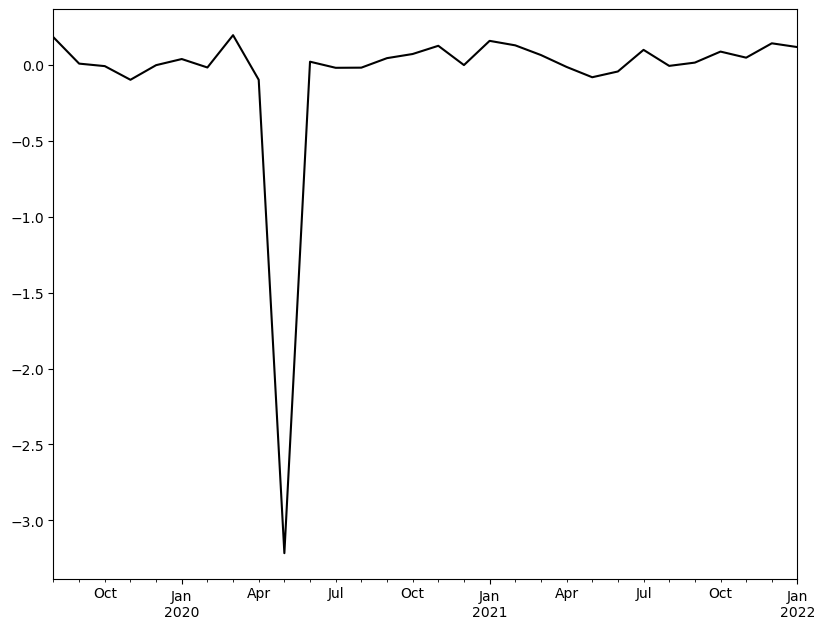

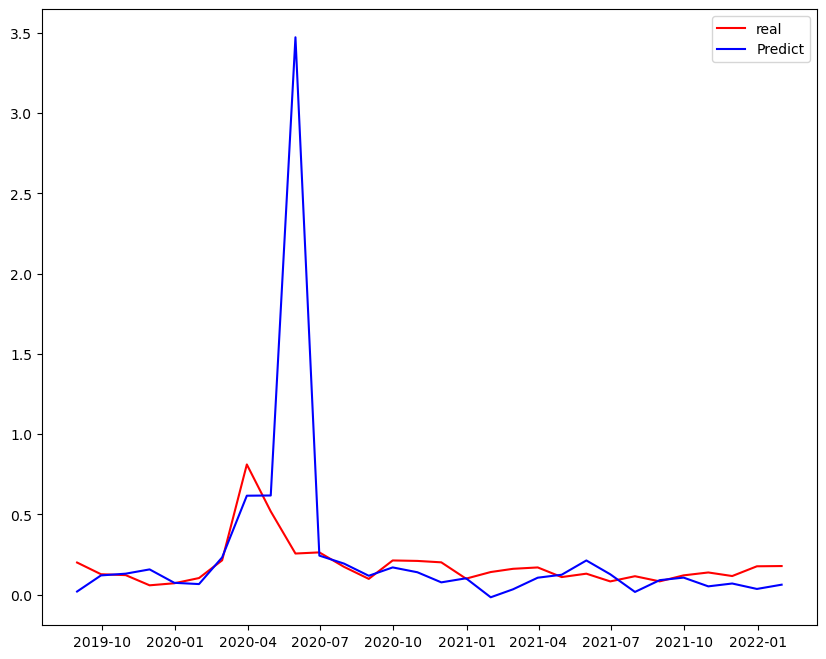

Mean Absolute Error : 0.17213948237744078
Mean Squared Error : 0.35211940770254996
Root Mean Squared Error : 0.5933965012557371


In [44]:
import matplotlib.pyplot as plt

y_hat = []

Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-30:]
X_out = pd.concat([df[['S_rv30']].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-30:]
X_out = sm.add_constant(X_out)

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-30]
X = sm.add_constant(X)

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-30]
factors = ['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_cad', 'FR_gbp', 'TED', 'DEF', 'HPI', 'M1']


for idx in range(len(Y_out)):

    reg = sm.OLS(Y.iloc[-30:], X[factors].iloc[-30:]).fit()

    y_f = reg.params @ X_out[factors].iloc[idx]
    y_hat.append(y_f)
    
    X = pd.concat([X, X_out.iloc[[idx]]])
    Y = pd.concat([Y, Y_out.iloc[[idx]]])
    
y_df = pd.DataFrame(y_hat, index=Y_out.index, columns=['y_pred'])
Y_out = pd.DataFrame(Y_out)
y_reg = pd.concat([y_df, Y_out], axis=1)

(y_reg['S_rv30'] - y_reg['y_pred']).plot(figsize=(9.6, 7.4), color='k')
plt.figure(figsize=(10,8))
plt.plot(y_reg['S_rv30'], color='r', label='real')
plt.plot(y_reg['y_pred'], color='b', label='Predict')
plt.legend()
plt.show()

def mae (y, y_hat):
    return sum(abs(y-y_hat)) / len(y_hat)
def mse (y, y_hat):
    return sum((y-y_hat)**2) / len(y_hat)
def rmse (y, y_hat):
    return np.sqrt(sum((y-y_hat)**2) / len(y_hat))
# def mse (y, y_hat):
#     return sum((y-y_hat)**2) / len(y_hat)
    
print(f'Mean Absolute Error : {mae(y_reg.S_rv30, y_reg.y_pred)}')
print(f'Mean Squared Error : {mse(y_reg.S_rv30, y_reg.y_pred)}')
print(f'Root Mean Squared Error : {rmse(y_reg.S_rv30, y_reg.y_pred)}')

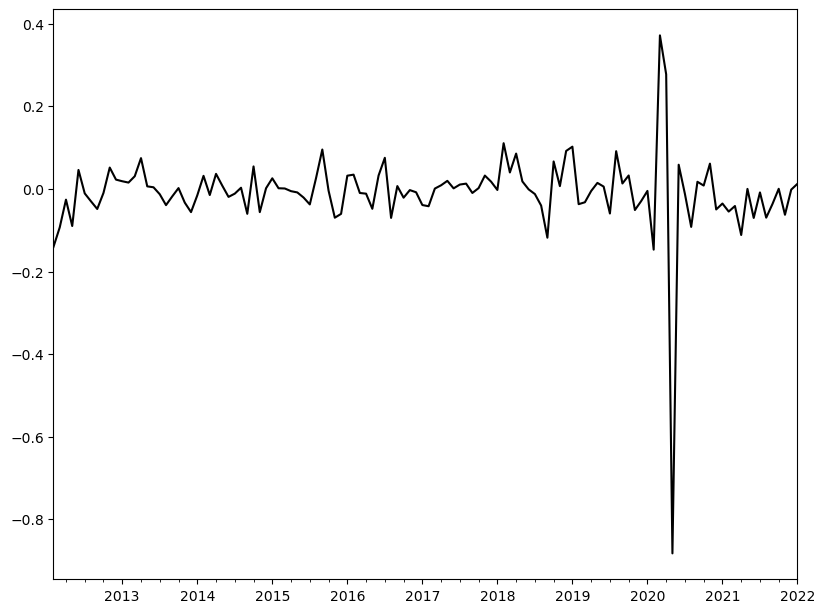

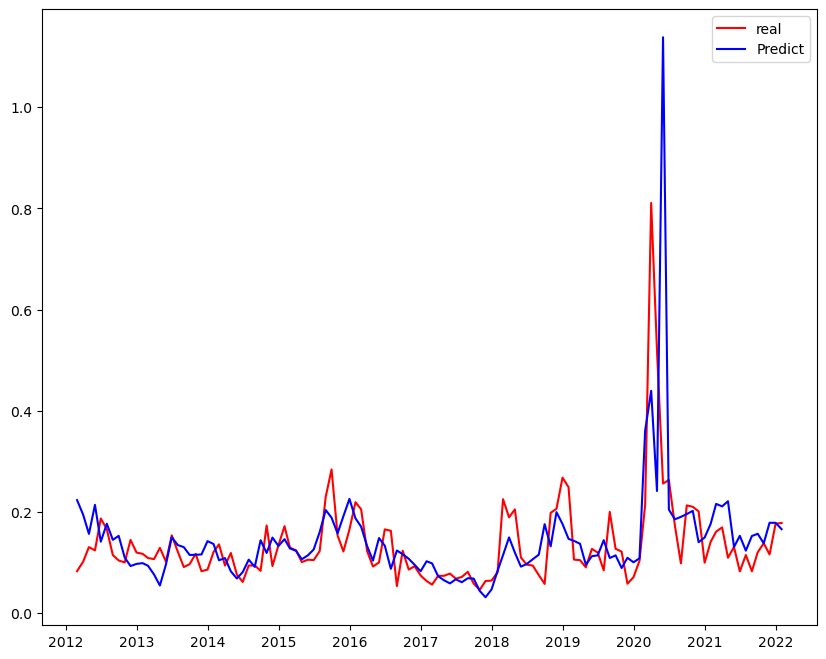

Mean Absolute Error : 0.047107826416955795
Mean Squared Error : 0.01052416473874489
Root Mean Squared Error : 0.10258735174837535


In [45]:
import matplotlib.pyplot as plt

y_hat = []

Y_out = df['S_rv30'].resample('m').last().loc[test.index].iloc[-120:]
X_out = pd.concat([df[['S_rv30']].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[-120:]
X_out = sm.add_constant(X_out)

X = pd.concat([df['S_rv30'].resample('m').last().shift(-1).loc[test.index], test], axis=1).iloc[:-120]
X = sm.add_constant(X)

Y = df['S_rv30'].resample('m').last().loc[test.index].iloc[:-120]
factors = ['const', 'S_rv30', 'EP', 'TB', 'TS', 'FR_cad', 'FR_gbp', 'TED', 'DEF', 'HPI', 'M1']


for idx in range(len(Y_out)):

    reg = sm.OLS(Y.iloc[-120:], X[factors].iloc[-120:]).fit()

    y_f = reg.params @ X_out[factors].iloc[idx]
    y_hat.append(y_f)
    
    X = pd.concat([X, X_out.iloc[[idx]]])
    Y = pd.concat([Y, Y_out.iloc[[idx]]])
    
y_df = pd.DataFrame(y_hat, index=Y_out.index, columns=['y_pred'])
Y_out = pd.DataFrame(Y_out)
y_reg = pd.concat([y_df, Y_out], axis=1)

(y_reg['S_rv30'] - y_reg['y_pred']).plot(figsize=(9.6, 7.4), color='k')
plt.figure(figsize=(10,8))
plt.plot(y_reg['S_rv30'], color='r', label='real')
plt.plot(y_reg['y_pred'], color='b', label='Predict')
plt.legend()
plt.show()

def mae (y, y_hat):
    return sum(abs(y-y_hat)) / len(y_hat)
def mse (y, y_hat):
    return sum((y-y_hat)**2) / len(y_hat)
def rmse (y, y_hat):
    return np.sqrt(sum((y-y_hat)**2) / len(y_hat))
# def mse (y, y_hat):
#     return sum((y-y_hat)**2) / len(y_hat)
    
print(f'Mean Absolute Error : {mae(y_reg.S_rv30, y_reg.y_pred)}')
print(f'Mean Squared Error : {mse(y_reg.S_rv30, y_reg.y_pred)}')
print(f'Root Mean Squared Error : {rmse(y_reg.S_rv30, y_reg.y_pred)}')

<AxesSubplot:>

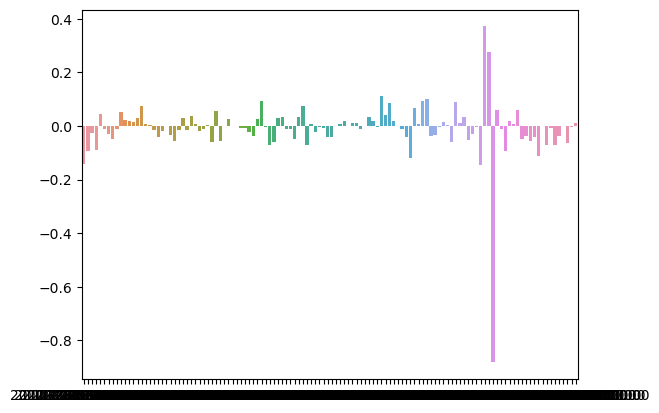

In [49]:
import seaborn as sns

sns.barplot(x=(y_reg['S_rv30'] - y_reg['y_pred']).index, y=(y_reg['S_rv30'] - y_reg['y_pred']))

In [59]:
(y_reg['S_rv30'] - y_reg['y_pred']).apply(lambda x : 100 * x).describe()

count    120.000000
mean      -0.839836
std       10.267170
min      -88.224911
25%       -3.676922
50%       -0.280908
75%        1.812034
max       37.151789
dtype: float64

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  2.,  4.,
         7.,  4., 12.,  6., 17., 21., 13.,  9.,  3.,  3.,  3.,  2.,  4.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-88.22491062, -86.97114362, -85.71737663, -84.46360963,
        -83.20984264, -81.95607565, -80.70230865, -79.44854166,
        -78.19477466, -76.94100767, -75.68724068, -74.43347368,
        -73.17970669, -71.92593969, -70.6721727 , -69.41840571,
        -68.16463871, -66.91087172, -65.65710472, -64.40333773,
        -63.14957073, -61.89580374, -60.64203675, -59.38826975,
        -58.13450276, -56.88073576, -55.62696877, 

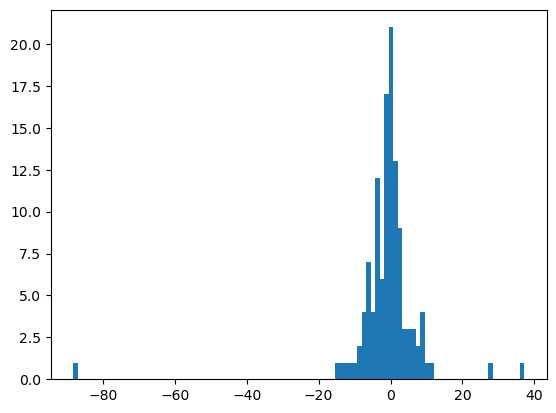

In [58]:
plt.hist((y_reg['S_rv30'] - y_reg['y_pred']) * 100, bins=100)